In [1]:
import numpy as np
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision.transforms as transforms


from bgan.datasets import make_semi_dataset_from_tensors, make_batch_generator
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
x_train, y_train = trainset.train_data.float() / 255, trainset.train_labels
x_test, y_test = testset.test_data.float() / 255, testset.test_labels
x_test = x_test[:, None, :, :].float()
y_test = y_test.numpy()

labeled, unlabeled = make_semi_dataset_from_tensors(x_train[:, None, :, :].float(), 
                                                    y_train[:, None], labeled_fraction=0.1)

# labeledloader = torch.utils.data.DataLoader(labeled, batch_size=50,
#                                           shuffle=True, num_workers=2)

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
    
class Network(nn.Module):
    
    def __init__(self, d=128, K=11):
        super(Network, self).__init__()
        self.K = K
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
#         self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)
        self.fc1 = nn.Linear(576, 50)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(50, self.K)

    # forward method
    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
#         x = F.relu(self.conv4(x))
#         print(x.size())
        x = x.view(-1, 576)
#         print(x.size())
        x = self.fc1_drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
#         x = F.softmax(self.fc2(x))

        return x

In [46]:
class SemiClassifier():
    
    def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
        self.net = net
        self._init_optimizer(lr)
    
    def loss(self, x_l, y_l, x_u=None):
        
        d_l = self.net.forward(x_l)
            
        ce = nn.NLLLoss()
        l_loss = ce(torch.log(d_l), y_l)
        loss = l_loss
        if x_u is not None:
            d_u = self.net.forward(x_u)
#             max_probs = torch.max(torch.log(d_u), 1)[0]
#             u_loss = torch.mean(-max_probs) / 10
#             loss += u_loss
            loss += -torch.sum(d_u * torch.log(d_u)) / 10
        
        return loss
        
    
    def _init_optimizer(self, lr):
        self.optimizer = optim.Adam(self.net.parameters(),
                lr=lr, betas=(0.5, 0.999))
        
    def step(self, x_l, y_l, x_u=None):
        
        self.net.zero_grad()
        loss = self.loss(x_l, y_l, x_u)   
        loss.backward()
        self.optimizer.step()
        return loss.data.numpy()
        
    def predict(self, x):
        return self.net.forward(x)
    
    
# class GANBasedClassifier():
    
#     def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
#         self.net = net
#         self._init_optimizer(lr)
    
#     def loss(self, x_l, y_l, x_u=None, z=None):
        
#         d_l = self.net.forward(x_l)
            
#         ce = nn.NLLLoss()
#         l_loss = ce(d_l, y_l)
#         loss = l_loss
#         if x_u is not None:
#             d_u = self.net.forward(x_u)
#             probs = F.softmax(d_u)
#             sum_probs = torch.sum(probs, 1)[:-1] # Right?
#             u_loss = -torch.mean(torch.log(sum_probs))
#             loss += u_loss
# #             loss += -torch.sum(d_u * torch.log(d_u)) / 10

#         if z is not None:
#             d_z = self.net.forward(z)
# #             d_z = self.net.forward_last_layers(z)
#             z_vals = torch.ones(z.size()[0]) * (self.net.K-1)
#             z_vals = Variable(z_vals, requires_grad=False).long()
#             z_loss = ce(d_z, z_vals)
#             loss += z_loss
        
#         return loss
        
    
#     def _init_optimizer(self, lr):
#         self.optimizer = optim.Adam(self.net.parameters(),
#                 lr=lr, betas=(0.5, 0.999))
        
#     def step(self, x_l, y_l, x_u=None, z=None):
        
#         self.net.zero_grad()
#         loss = self.loss(x_l, y_l, x_u, z)   
#         loss.backward()
#         self.optimizer.step()
#         return loss.data.numpy()
        
#     def predict(self, x):
#         return F.softmax(self.net.forward(x))

class GANBasedClassifier():
    
    def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
        self.net = net
        self._init_optimizer(lr)
    
    def loss(self, x_l, y_l, x_u=None, z=None):
        
        stability_fix = 1e-8
        d_l = self.net.forward(x_l)
            
        ce = nn.CrossEntropyLoss()
        l_loss = ce(d_l, y_l)
        loss = l_loss
        if x_u is not None:
            d_u = self.net.forward(x_u)
            probs_u = F.softmax(d_u)
            sum_probs = torch.sum(probs_u, 1)[:-1] # Right?
            u_loss = -torch.mean(torch.log(sum_probs + stability_fix))
            loss += u_loss
            loss += -torch.mean(torch.sum(probs_u * torch.log(probs_u + stability_fix), 1))
            

        if z is not None:
            d_z = self.net.forward(z)
#             d_z = self.softmax(dz)
            z_vals = torch.ones(z.size()[0]) * (self.net.K-1)
            z_vals = Variable(z_vals, requires_grad=False).long()
            z_loss = ce(d_z, z_vals) / 3
            loss += z_loss
#         print(loss)
        
        return loss
        
    
    def _init_optimizer(self, lr):
        self.optimizer = optim.Adam(self.net.parameters(),
                lr=lr, betas=(0.5, 0.999))
        
    def step(self, x_l, y_l, x_u=None, z=None):
        
        self.net.zero_grad()
        loss = self.loss(x_l, y_l, x_u, z)   
        loss.backward()
        self.optimizer.step()
        return loss.data.numpy()
        
    def predict(self, x):
        d = self.net.forward(x)
        return F.softmax(d)
    
    
    
def make_z_gen(batch_size):
    while True:
        z = 2 * (np.random.rand(batch_size, 50))#.reshape([batch_size, 1, 28, 28])
        z = torch.from_numpy(z).float()
        yield Variable(z, requires_grad=False)
        
def make_z_gen_from_unlabeled(batch_size, dataset):
    ds_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=2)
    while True:
        for batch in ds_loader:
            z = .2 * (np.random.rand(batch.size()[0], 784) - 0.5).reshape([batch.size()[0], 1, 28, 28])
#             z = torch.from_numpy(z).float()
#             z = Variable(z, requires_grad=False)

#             x = np.flip(batch.numpy(), axis=2).copy()
#             x = torch.from_numpy(x).float()
#             x = batch.permute(0, 1, 3, 2)
#             x = Variable(x, requires_grad=False)

            x = batch.numpy()
            x = (x + x[::-1])/2
            x = x + z
            x = Variable(torch.from_numpy(x), requires_grad=False).float()
    
#             x[x > 1.] = 1.
#             x[x < 0.] = 0.
            yield x

## GAN-like

In [47]:
net = Network(d=16, K=11)
net.apply(weights_init)
model_gan = GANBasedClassifier(net, lr=5e-4)

In [48]:
labeled_gen = make_batch_generator(labeled, 50)
unlabeled_gen = make_batch_generator(unlabeled, 50)
# z_gen = make_z_gen(50)
z_gen = make_z_gen_from_unlabeled(50, unlabeled)

In [49]:
mean_loss = 0
t = 0

for i in range(20000):
    x_l, y_l = next(labeled_gen)
    x_u = next(unlabeled_gen)
    z = next(z_gen)
    
    if not ((i+1) % 100):
        print(i+1, mean_loss/t)
        mean_loss = 0
        t = 0
        
    if not((i+1) % 500):
        preds_prob = model_gan.predict(Variable(x_test)).data.numpy()[:, :-1]
        preds_class = np.argmax(preds_prob, axis=1)
        print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])
    loss = model_gan.step(x_l, y_l, x_u, z)
    mean_loss += loss
    t += 1


100 [ 4.42813921]
200 [ 2.09346628]
300 [ 0.95730448]
400 [ 0.54751623]
500 [ 0.42088097]
	Accuracy: 0.9411
600 [ 0.32764041]
700 [ 0.27498817]
800 [ 0.2449342]
900 [ 0.19954516]
1000 [ 0.18866451]
	Accuracy: 0.9576
1100 [ 0.17002305]
1200 [ 0.14594945]
1300 [ 0.13555263]
1400 [ 0.12035219]
1500 [ 0.1015581]
	Accuracy: 0.9642
1600 [ 0.10086226]
1700 [ 0.09929861]
1800 [ 0.09625833]
1900 [ 0.08331797]
2000 [ 0.07635426]
	Accuracy: 0.9668
2100 [ 0.07596937]
2200 [ 0.07207195]
2300 [ 0.07191485]
2400 [ 0.07681382]
2500 [ 0.06966086]
	Accuracy: 0.9692
2600 [ 0.06900261]
2700 [ 0.05323553]
2800 [ 0.06887281]
2900 [ 0.05646901]
3000 [ 0.05872469]
	Accuracy: 0.9697
3100 [ 0.05031718]
3200 [ 0.06150445]
3300 [ 0.05303931]
3400 [ 0.05745563]
3500 [ 0.05529197]
	Accuracy: 0.9663
3600 [ 0.06106005]
3700 [ 0.0511173]
3800 [ 0.04475059]
3900 [ 0.03839761]
4000 [ 0.04638686]
	Accuracy: 0.9721
4100 [ 0.03655483]
4200 [ 0.04608806]
4300 [ 0.03989833]
4400 [ 0.04335951]
4500 [ 0.04302717]
	Accuracy: 0.

Process Process-437:
Process Process-445:
Process Process-438:
Process Process-440:
Process Process-446:
Process Process-439:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", lin

KeyboardInterrupt: 

In [28]:
z = next(z_gen)

In [29]:
imgs = z.data.numpy()

In [30]:
z[:, :, ::2].size()

torch.Size([50, 1, 14, 28])

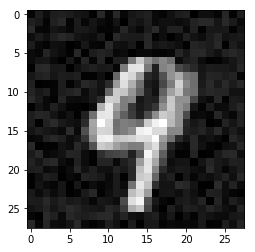

In [31]:
plt.imshow(imgs[4, 0], cmap='gray')

In [98]:
preds_class[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [100]:
np.sum(y_test == preds_class)

980

In [101]:
preds_prob = model_gan.predict(Variable(x_test)).data.numpy()[:, :-1]
preds_class = np.argmax(preds_prob, axis=1)
print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])

	Accuracy: 0.098


## Supervised

In [66]:
net_sup = Network(d=16, K=10)
net_sup.apply(weights_init)
model_sup = SemiClassifier(net_sup, lr=1e-2)

In [67]:
labeled_gen = make_batch_generator(labeled, 50)

In [69]:
mean_loss = 0
t = 0
for i in range(5000):
    x_l, y_l = next(labeled_gen)
    if not ((i+1) % 100):
        print(i, mean_loss/t)
        mean_loss = 0
        t = 0
    if not((i+1) % 500):
        preds_prob = model_sup.predict(Variable(x_test)).data.numpy()
        preds_class = np.argmax(preds_prob, axis=1)
        print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])
    loss_sup = model_sup.step(x_l, y_l)
    mean_loss += loss_sup
    t += 1

99 [ 0.03584554]
199 [ 0.02163391]
299 [ 0.03043898]
399 [ 0.02567868]
499 [ 0.01260155]
	Accuracy: 0.9872
599 [ 0.01504184]
699 [ 0.00961216]
799 [ 0.00618663]
899 [ 0.01370139]
999 [ 0.01684636]
	Accuracy: 0.9861
1099 [ 0.0221732]
1199 [ 0.01092714]
1299 [ 0.00775784]
1399 [ 0.0182983]
1499 [ 0.00542831]
	Accuracy: 0.9867
1599 [ 0.00752426]
1699 [ 0.00876954]
1799 [ 0.02434348]
1899 [ 0.01653739]
1999 [ 0.01294875]
	Accuracy: 0.9838
2099 [ 0.01907762]
2199 [ 0.02272564]
2299 [ 0.02949499]
2399 [ 0.01829935]
2499 [ 0.01886867]
	Accuracy: 0.9869
2599 [ 0.01408803]
2699 [ 0.01484888]
2799 [ 0.00935343]
2899 [ 0.01319065]
2999 [ 0.00892878]
	Accuracy: 0.9882
3099 [ 0.01920759]
3199 [ 0.01908769]
3299 [ 0.01703345]
3399 [ 0.01535782]
3499 [ 0.01732407]
	Accuracy: 0.9873
3599 [ 0.01383578]


Process Process-42:
Process Process-41:
Traceback (most recent call last):
KeyboardInterrupt
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()


KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 342, in get
    res = self._reader.recv_bytes()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Library/Frameworks/Python.fr

In [57]:
preds_prob = model_sup.predict(Variable(x_test)).data.numpy()
preds_class = np.argmax(preds_prob, axis=1)

### Semi-supervised

In [119]:
net_semi = Network(10)
net_semi.apply(weights_init)
model_semi = SemiClassifier(net_semi, lr=1e-3)

In [120]:
labeled_gen = make_batch_generator(labeled, 50)
unlabeled_gen = make_batch_generator(unlabeled, 50)


In [29]:
# def make_random_gen(batch_size, shape=50):
#     while True:
#         z = np.random.rand(batch_size, shape)* 2 - 1
#         return Variable(z, requires_grad=False).float()

In [30]:
mean_loss = 0
t = 0
for i in range(5000):
    x_l, y_l = next(labeled_gen)
    x_u = next(unlabeled_gen)
    if not ((i+1) % 100):
        print(i+1, mean_loss/t)
        mean_loss = 0
        t = 0
    if not((i+1) % 500):
        preds_prob = model_semi.predict(Variable(x_test)).data.numpy()
        preds_class = np.argmax(preds_prob, axis=1)
        print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])
    loss = model_semi.step(x_l, y_l, x_u)
    mean_loss += loss
    t += 1

100 [ 1.69764185]
200 [ 1.15048254]
300 [ 1.04159737]
400 [ 1.01232195]
500 [ 0.91960853]
	Accuracy: 0.9171
600 [ 0.81323296]
700 [ 0.8691057]
800 [ 0.81949717]
900 [ 0.80083632]
1000 [ 0.79485357]
	Accuracy: 0.9313
1100 [ 0.77135831]
1200 [ 0.7276867]
1300 [ 0.7102173]
1400 [ 0.71404135]
1500 [ 0.68416327]
	Accuracy: 0.9233
1600 [ 0.7508902]
1700 [ 0.73940122]
1800 [ 0.7443341]
1900 [ 0.72703522]
2000 [ 0.68475431]
	Accuracy: 0.933
2100 [ 0.65783495]
2200 [ 0.74128538]
2300 [ 0.74749136]
2400 [ 0.7388925]
2500 [ 0.71143442]
	Accuracy: 0.9358
2600 [ 0.68153191]
2700 [ 0.69175285]
2800 [ 0.68161893]
2900 [ 0.73074555]
3000 [ 0.644777]
	Accuracy: 0.9342
3100 [ 0.70305097]
3200 [ 0.72644961]
3300 [ 0.76000029]
3400 [ 0.64694488]
3500 [ 0.68373251]
	Accuracy: 0.938
3600 [ 0.60520154]
3700 [ 0.6878565]
3800 [ 0.71089464]
3900 [ 0.69952399]
4000 [ 0.64404511]
	Accuracy: 0.9311


Process Process-167:
Process Process-179:
Process Process-180:
Process Process-168:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions

KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
